# Information retrieval project : Sentiment Analysis

# CNN

In [1]:
import re
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random

## Data

There are two files: one with positive reviews (imdb.pos) and one with negative reviews (imdb.neg). Each file contains 300000 reviews, one per line.


The following functions can be used to load and clean the data.

In [2]:
# Tokenize a sentence
def clean_str(string, tolower=True):
    """
    Tokenization/string cleaning.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    if tolower:
        string = string.lower()
        
    return string.strip()


# reads the content of the file passed as an argument.
# if limit > 0, this function will return only the first "limit" sentences in the file.
def loadTexts(filename, limit=-1):
    f = open(filename)
    dataset=[]
    line =  f.readline()
    cpt=1
    skip=0
    while line :
        cleanline = clean_str(f.readline()).split()
        #cleanline = line
        if cleanline: 
            dataset.append(cleanline)
        else: 
            line = f.readline()
            skip+=1
            continue
        if limit > 0 and cpt >= limit: 
            break
        line = f.readline()
        cpt+=1        
        
    f.close()
    print("Load ", cpt, " lines from ", filename , " / ", skip ," lines discarded")
    return dataset


The following cell load the first 5000 sentences in each review set.

In [3]:
LIM=7000
txtfile = "imdb.pos"  # path of the file containing positive reviews
postxt = loadTexts(txtfile,limit=LIM)
txtfile = "imdb.neg"  # path of the file containing negative reviews
negtxt = loadTexts(txtfile,limit=LIM)

Load  7000  lines from  imdb.pos  /  1  lines discarded
Load  7000  lines from  imdb.neg  /  3  lines discarded


In [4]:
txt = postxt + negtxt # construct the data set
label = list(np.ones(LIM, int))+list(np.zeros(LIM, int)) # construct the label set; 1 for positive review and 0 for negative review

Split the data between train / dev / test.

In [5]:
from sklearn.model_selection import train_test_split

txt_train, txt_dev, label_train, label_dev = train_test_split(txt, label, test_size=0.1, random_state=26 ,stratify=label)

txt_train, txt_test, label_train, label_test = train_test_split(txt_train , label_train , test_size=0.1, random_state = 26 , stratify=label_train)

# Converting data to Pytorch tensors

Here, we convert data to Pytorch tensors so they can be used in a neural network.
To do that, we first create a dictionnary that map words to integers(word occurence).
In this dictionnary, we only add words that are in the training set.

In [6]:
class Dict:
    def __init__(self, words, unk=None):
        self._unk = unk
        self._word_to_id = dict()
        self._id_to_word = list()

        if unk in words:
            raise RuntimeError("UNK word exists in vocabulary")

        if unk is not None:
            self.unk_index = self._add_word(unk)

        for word in words:
            self._add_word(word)

    # for internal use only!
    def _add_word(self, word):
        if word not in self._word_to_id:
            id = len(self._id_to_word)
            self._word_to_id[word] = id
            self._id_to_word.append(word)
            return id
        else:
            return self._word_to_id[word]

    def str_to_id(self, word):
        if self._unk is not None:
            return self._word_to_id.get(word, self.unk_index)
        else:
            return self._word_to_id[word]

    def id_to_str(self, id):
        return self._id_to_word[id]

    def __len__(self):
        return len(self._word_to_id)

    def has_unk(self):
        return self._unk is not None
    
    def unk(self):
        return self.unk_index

In [7]:
#Creating a dictionary where each word is associated to an index
word_index = {}
for sentence in txt:
    for word in sentence:
        if word not in word_index:
            word_index[word] = len(word_index) + 1

In [8]:
Dict_index = Dict(word_index, unk=True)

## Training function

In [9]:
def train(model , epochs, X_train ,y_train , X_dev , y_dev , optimizer, lr):   
        
    #variables to see the progression
    mean_loss_train = []
    mean_loss_dev = []
    accuracy_train = []
    accuracy_dev = []
    
    
    #passe le modele en mode training
    model.train()
    
    for i in range(epochs):
        
        #Adaptive lrlearning rate
        if((i+1)%2 == 0):
            for f in optimizer.param_groups:
                f['lr'] = f['lr']*0.75
                
        #defining parameters to print the evolution of the NN
        accuracy = 0
        mean_loss = 0
        
        #shuffle to reduce overfitting
        d = list(zip(X_train, y_train))
        np.random.shuffle(d)
        X_train, y_train = zip(*d)
        
        for sentence,label in zip(X_train , y_train):
            
            # initialize the parameters gradient to zero
            optimizer.zero_grad()
            
            #Creating the tensors for inputs
            data = torch.LongTensor([Dict_index.str_to_id(word) for word in sentence])
            label = torch.Tensor([label])
            #prediction and loss
            prediction = model(data)
            loss_out = loss(prediction , label)
            mean_loss+=loss_out.item()
            
            #Backward and updates
            loss_out.backward()
            optimizer.step()

            #Computing accuracy
            if (prediction >= 0.5 and label==1) or (prediction<0.5 and label==0):
                accuracy += 1
            
        mean_loss_train.append(mean_loss/len(X_train))
        accuracy_train.append(accuracy/len(X_train))
        
        print("EPOCH" , str(i+1) ,"On the training data : mean loss is :" , mean_loss/len(X_train) , "accuracy is: " ,accuracy/len(X_train))


        mean_loss = 0
        accuracy = 0
        
        #testing on dev data
        for sentence,label in zip(X_dev,y_dev):
            data = torch.LongTensor([Dict_index.str_to_id(word) for word in sentence])
            label = torch.Tensor([label])
            
            #prediction and loss
            prediction = model(data)
            loss_out = loss(prediction , label)
            
            mean_loss+=loss_out.item()
            
            
            #computing accuracy
            if (prediction >= 0.5 and label==1) or (prediction < 0.5 and label==0):
                accuracy += 1
            
        print("EPOCH" , str(i+1) ,"On the dev data : mean loss is : " , mean_loss/len(X_dev) , " accuracy is : " ,accuracy/len(X_dev))
        print("----------------------------------------------------------------------------")
        mean_loss_dev.append(mean_loss/len(X_dev))
        accuracy_dev.append(accuracy/len(X_dev))
          
            
            
    #Plotting accuracy curves for dev and train data
    plt.figure()
    plt.plot(accuracy_train , label='Train')
    plt.plot(accuracy_dev, label="Dev")
    plt.title("Accuracy in term of epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    #Plotting loss curves for dev and train data
    plt.figure()    
    plt.plot(mean_loss_train , label='Train')
    plt.plot(mean_loss_dev, label="Dev")
    plt.title("Loss in term of epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

In [10]:
#Calculating accuracy on test data
def test_accuracy(model,  X_test , y_test):
    
    accuracy = 0
    mean_loss = 0
        
    for sentence,label in zip(X_test,y_test):
        data = torch.LongTensor([Dict_index.str_to_id(word) for word in sentence])
        label = torch.Tensor([label])
             
        pred = model(data)
        loss_out = loss(pred , label)
        mean_loss += loss_out.item()
                        
            
        #computing accuracy
        if (pred >= 0.5 and label==1) or (pred<0.5 and label==0):
            accuracy += 1

            
    print("Accuracy on test set for this model is" , accuracy/len(X_test))
    return(accuracy/len(X_test))

## CNN classifier

In [11]:
def reg(inputs,kernel_size):
    
    if(inputs.shape[0]<kernel_size):
        pad = torch.tensor([0 for i in range(kernel_size-inputs.shape[0])])
        inputs = torch.cat((inputs, pad), 0)
    return(inputs)  

def Conv(inputs,kernel_size, conv):
    concat_inp = []
    for i in range(inputs.shape[0]-kernel_size+1):
        Y = [inputs[j] for j in range(i, kernel_size+i)]
        concat = torch.cat(Y, 0)
        concat_inp.append(F.relu(conv(concat)) )
    return(concat_inp)

def Pooling(concat_list,pool_choice):
    
    h_ = torch.stack(concat_list)
    if pool_choice == "max":
        h_, _ = torch.max(h_, 0)
    if pool_choice == "mean":
        h_ = torch.mean(h_, 0)        
    return(h_)

def rec(proj,h,index):
    
    if index == len(proj)-1 :
        return(proj[index](h))
    
    z = torch.tanh(proj[index](h))
    index +=1
    return(rec(proj,z,index))

In [12]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, kernel_size, feature_size, pool_choice):
        super(CNN, self).__init__()
        
        #Parameters
        self.kernel_size = kernel_size
        self.feature_size = feature_size
        self.pool_choice  = pool_choice        

        #Embedding layer
        self.embeddings = nn.Embedding(num_embeddings = vocab_size, embedding_dim=embedding_dim)
        
        #Convolution layer
        self.convs = nn.ModuleList([nn.Linear(embedding_dim*kernel_size[i],feature_size[0]) for i in range(len(kernel_size))])
        
        #output projection
        self.projs = nn.ModuleList([nn.Linear(feature_size[0]*len(kernel_size),feature_size[1])]+ 
                                   [nn.Linear(feature_size[i],feature_size[i+1])
                                    for i in range(1,len(feature_size)-1)])
        
        # Parameter initialization  
        for i in range(len(self.projs)):
            nn.init.xavier_uniform_(self.projs[i].weight.data)
            nn.init.zeros_(self.projs[i].bias.data)
            
        #dropout
        #self.dropout = nn.Dropout(p=0.5)  
        
    def forward(self, inputs):
        
        kernel_size = self.kernel_size
        pool_choice = self.pool_choice        
        #prepare the inputs
        inputs = [reg(inputs,kernel_size[i]) for i in range(len(kernel_size))]
        
        #Embending
        inp = [self.embeddings(inputs[i]) for i in range(len(kernel_size))]

        #Conv
        concat_inp = [Conv(inp[i],kernel_size[i], self.convs[i]) for i in range(len(kernel_size))]
        
        #Pooling
        h = [Pooling(concat_inp[i],pool_choice) for i in range(len(kernel_size))]
        
        #Concatenate the two output of convolution layer
        res = torch.cat(h,0)
        
        output = rec(self.projs,res,0)

        return output

## Testing part

### kernel size = 1


In [13]:
emb  = 10
feat = [5,1]
size = [1]
lr = 0.1

EPOCH 1 On the training data : mean loss is : 0.6436230435136922 accuracy is:  0.5714285714285714
EPOCH 1 On the dev data : mean loss is :  0.5768716305963816  accuracy is :  0.6278571428571429
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.5469323996964482 accuracy is:  0.685273368606702
EPOCH 2 On the dev data : mean loss is :  0.5427790593786014  accuracy is :  0.7157142857142857
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.4887571874591868 accuracy is:  0.7367724867724867
EPOCH 3 On the dev data : mean loss is :  0.49582146475443833  accuracy is :  0.7014285714285714
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.41194153880623136 accuracy is:  0.7945326278659612
EPOCH 4 On the dev data : mean loss is :  0.465458422389043  accuracy is :  0.7421428571

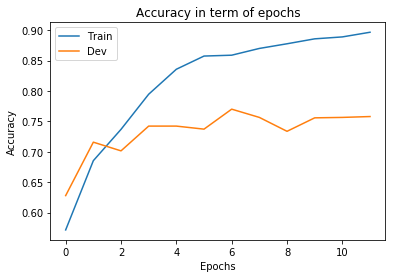

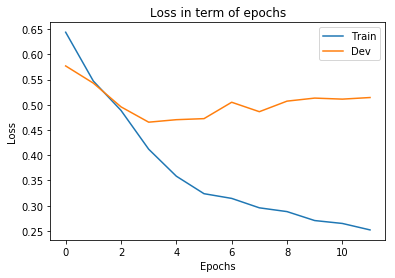

In [16]:
model_7 = CNN(len(Dict_index), emb, size, feat, pool_choice = "mean")
loss = nn.BCEWithLogitsLoss()
optimizer_SGD = torch.optim.SGD(params=model_7.parameters(), lr=lr, weight_decay=1e-3)
train(model_7 , 12,txt_train ,label_train, txt_dev, label_dev, optimizer_SGD, lr)

In [17]:
test_accuracy(model_7,  txt_test , label_test)

Accuracy on test set for this model is 0.7595238095238095


0.7595238095238095

### kernel size = 2, pool = max

In [13]:
emb  = 10
feat = [5,1]
size = [2]
lr = 0.1

EPOCH 1 On the training data : mean loss is : 0.6727226213596509 accuracy is:  0.55
EPOCH 1 On the dev data : mean loss is :  0.6261594230981011  accuracy is :  0.5857142857142857
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.583299847295376 accuracy is:  0.6360670194003527
EPOCH 2 On the dev data : mean loss is :  0.5348200917297176  accuracy is :  0.6735714285714286
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.48954048894164 accuracy is:  0.7339506172839506
EPOCH 3 On the dev data : mean loss is :  0.5023453810907501  accuracy is :  0.7235714285714285
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.42403009132626424 accuracy is:  0.791710758377425
EPOCH 4 On the dev data : mean loss is :  0.4645402372495404  accuracy is :  0.7435714285714285
----------

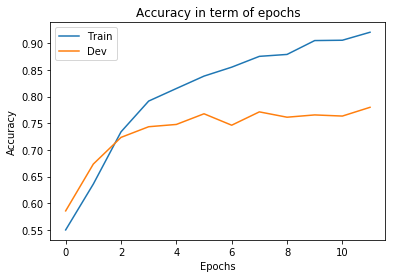

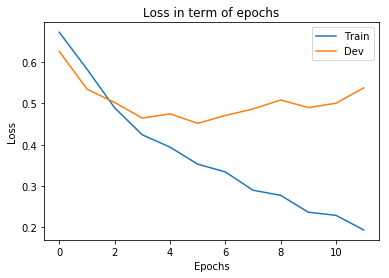

In [14]:
model_1 = CNN(len(Dict_index), emb, size, feat, pool_choice = "max")
loss = nn.BCEWithLogitsLoss()
optimizer_SGD = torch.optim.SGD(params=model_1.parameters(), lr=lr, weight_decay=1e-3)
train(model_1 , 12,txt_train ,label_train, txt_dev, label_dev, optimizer_SGD, lr)

In [15]:
test_accuracy(model_1,  txt_test , label_test)

Accuracy on test set for this model is 0.7801587301587302


0.7801587301587302

### kernel size = 2, pool = mean

In [16]:
emb  = 10
feat = [5,1]
size = [2] # change
lr = 0.1

EPOCH 1 On the training data : mean loss is : 0.6335792906755805 accuracy is:  0.5936507936507937
EPOCH 1 On the dev data : mean loss is :  0.5802381586140557  accuracy is :  0.5878571428571429
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.5097793944162965 accuracy is:  0.7052028218694886
EPOCH 2 On the dev data : mean loss is :  0.4911504237184015  accuracy is :  0.755
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.4472851725864834 accuracy is:  0.7680776014109347
EPOCH 3 On the dev data : mean loss is :  0.4501450779402249  accuracy is :  0.7235714285714285
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.3926585515438515 accuracy is:  0.8106701940035274
EPOCH 4 On the dev data : mean loss is :  0.45950703904027873  accuracy is :  0.7635714285714286
-----

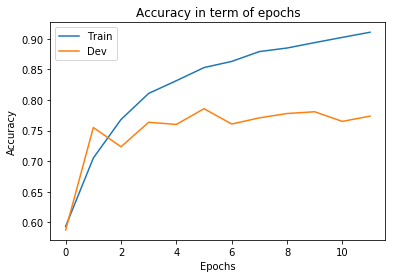

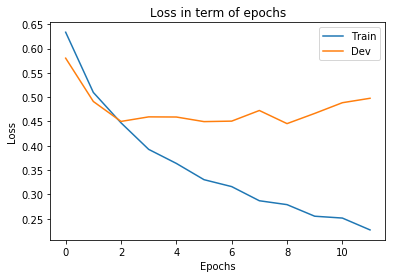

In [17]:
model_2 = CNN(len(Dict_index), emb, size, feat, pool_choice = "mean")
optimizer_SGD = torch.optim.SGD(params=model_2.parameters(), lr=lr, weight_decay=1e-3)
train(model_2, 12, txt_train, label_train, txt_dev, label_dev, optimizer_SGD , lr)

In [18]:
test_accuracy(model_2,  txt_test , label_test)

Accuracy on test set for this model is 0.807936507936508


0.807936507936508

### 2 kernels of size 2 and 3, pool = max

In [19]:
emb  = 10
feat = [5,1]
size = [2,3]
lr = 0.1

EPOCH 1 On the training data : mean loss is : 0.6540577021194417 accuracy is:  0.564021164021164
EPOCH 1 On the dev data : mean loss is :  0.6303150054552992  accuracy is :  0.6585714285714286
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.5476749164985375 accuracy is:  0.6797178130511464
EPOCH 2 On the dev data : mean loss is :  0.49626126358052713  accuracy is :  0.7185714285714285
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.4752260725441474 accuracy is:  0.7502645502645503
EPOCH 3 On the dev data : mean loss is :  0.5308294246766101  accuracy is :  0.6892857142857143
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.4162879365662507 accuracy is:  0.8006172839506173
EPOCH 4 On the dev data : mean loss is :  0.49760559861830966  accuracy is :  0.711428571

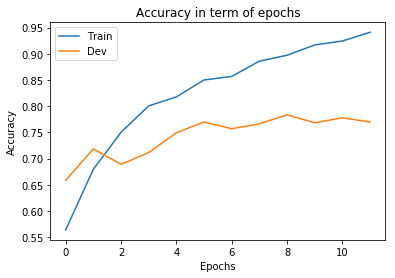

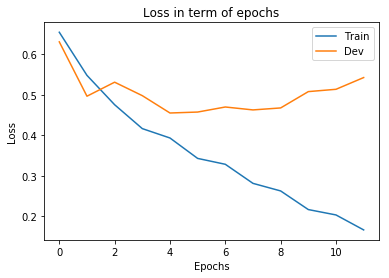

In [20]:
loss = nn.BCEWithLogitsLoss()
model_3 = CNN(len(Dict_index), emb, size, feat, pool_choice = "max")
optimizer_SGD = torch.optim.SGD(params=model_3.parameters(), lr=lr, weight_decay=1e-3)
train(model_3, 12,txt_train ,label_train, txt_dev, label_dev, optimizer_SGD , lr)

In [21]:
test_accuracy(model_3,  txt_test , label_test)

Accuracy on test set for this model is 0.7880952380952381


0.7880952380952381

### 2 kernels of size 2 and 3, pool = mean

EPOCH 1 On the training data : mean loss is : 0.6547811443305631 accuracy is:  0.5710758377425044
EPOCH 1 On the dev data : mean loss is :  0.5769449237067393  accuracy is :  0.6571428571428571
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.5123804900648984 accuracy is:  0.7139329805996473
EPOCH 2 On the dev data : mean loss is :  0.4933251273537136  accuracy is :  0.735
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.44987277506366724 accuracy is:  0.7713403880070546
EPOCH 3 On the dev data : mean loss is :  0.47275043549121604  accuracy is :  0.7764285714285715
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.39272849129039467 accuracy is:  0.8120811287477954
EPOCH 4 On the dev data : mean loss is :  0.4512010341263814  accuracy is :  0.7557142857142857
---

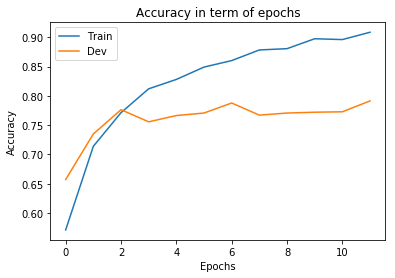

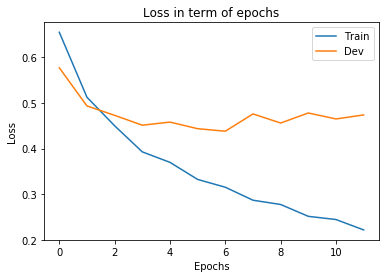

In [22]:
loss = nn.BCEWithLogitsLoss()
model_4 = CNN(len(Dict_index), emb, size, feat, pool_choice = "mean")
optimizer_SGD = torch.optim.SGD(params=model_4.parameters(), lr=lr, weight_decay=1e-3)
train(model_4, 12,txt_train ,label_train, txt_dev, label_dev, optimizer_SGD , lr)

In [23]:
test_accuracy(model_4,  txt_test , label_test)

Accuracy on test set for this model is 0.8111111111111111


0.8111111111111111

### 2 kernels of size 1 and 2, pool = mean

In [13]:
emb  = 10
feat = [5,1]
size = [1,2]
lr = 0.1

EPOCH 1 On the training data : mean loss is : 0.6280817314503219 accuracy is:  0.6061728395061728
EPOCH 1 On the dev data : mean loss is :  0.5443213190811158  accuracy is :  0.675
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.5076051846583375 accuracy is:  0.7159611992945326
EPOCH 2 On the dev data : mean loss is :  0.49842394826063763  accuracy is :  0.7492857142857143
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.4494518466594818 accuracy is:  0.7682539682539683
EPOCH 3 On the dev data : mean loss is :  0.47177391415374553  accuracy is :  0.755
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.38778407064466314 accuracy is:  0.8119047619047619
EPOCH 4 On the dev data : mean loss is :  0.45841951197838493  accuracy is :  0.7714285714285715
---------------

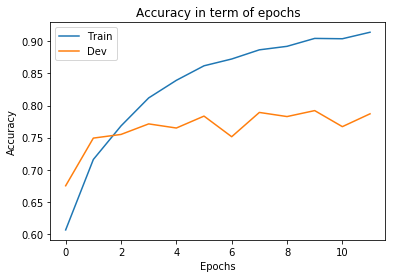

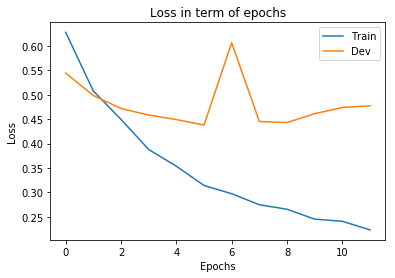

In [14]:
loss = nn.BCEWithLogitsLoss()
model_5 = CNN(len(Dict_index), emb, size, feat, pool_choice = "mean")
optimizer_SGD = torch.optim.SGD(params=model_5.parameters(), lr=lr, weight_decay=1e-3)
train(model_5, 12, txt_train ,label_train, txt_dev, label_dev, optimizer_SGD , lr)

In [15]:
test_accuracy(model_5,  txt_test , label_test)

Accuracy on test set for this model is 0.8023809523809524


0.8023809523809524

### 3 kernels of size 1, 2 and 3, pool = mean

In [14]:
emb  = 10
feat = [5,1]
size = [1,2,3]
lr = 0.1

EPOCH 1 On the training data : mean loss is : 0.6237407450184945 accuracy is:  0.6064373897707231
EPOCH 1 On the dev data : mean loss is :  0.5351369650446447  accuracy is :  0.6335714285714286
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.5097902481119362 accuracy is:  0.7229276895943563
EPOCH 2 On the dev data : mean loss is :  0.4854787366744491  accuracy is :  0.7042857142857143
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.450571553765304 accuracy is:  0.7734567901234568
EPOCH 3 On the dev data : mean loss is :  0.4967766166564586  accuracy is :  0.6914285714285714
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.40187986216078786 accuracy is:  0.809700176366843
EPOCH 4 On the dev data : mean loss is :  0.45595555295994405  accuracy is :  0.7328571428

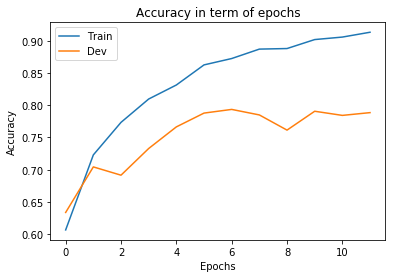

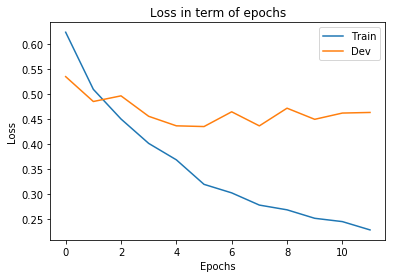

In [27]:
loss = nn.BCEWithLogitsLoss()
model_6 = CNN(len(Dict_index), emb, size, feat, pool_choice = "mean")
optimizer_SGD = torch.optim.SGD(params=model_6.parameters(), lr=lr, weight_decay=1e-3)
train(model_6, 12, txt_train ,label_train, txt_dev, label_dev, optimizer_SGD , lr)

In [20]:
test_accuracy(model_6,  txt_test , label_test)

Accuracy on test set for this model is 0.8047619047619048


0.8047619047619048